In [1]:
import numpy as np
import pandas as pd
from experimentalis import Dataset, GraphingOptions
from experimentalis.fitting import autofit, print_results
from experimentalis.extension.sde import GBM, LearnedDriftGBM

2026-01-23 01:35:26.805500: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


For this example, we'll try using Experimentalis routines to fit real stock data wonderfully ~~stolen~~ borrowed indefinitely from [plotly](https://github.com/plotly/datasets/blob/master/stockdata.csv). This dataset is pre-downloaded, and we can just load it up to begin.

In [2]:
df = pd.read_csv('./stockdata.csv')
df

,MSFT,IBM,SBUX,AAPL,GSPC,Date
0,23.950705,80.517962,16.149666,11.086612,1416.599976,2007-01-03
1,23.910599,81.378851,16.167992,11.332687,1418.339966,2007-01-04
2,23.774242,80.642129,16.099269,11.251984,1409.709961,2007-01-05
3,24.006852,81.867244,16.039710,11.307550,1412.839966,2007-01-08
4,24.030914,82.835742,15.970989,12.246870,1412.109985,2007-01-09
...,...,...,...,...,...,...
2301,51.360001,132.800003,58.110001,96.099998,1929.800049,2016-02-24
2302,52.099998,134.500000,58.750000,96.760002,1951.699951,2016-02-25
2303,51.299999,132.029999,58.340000,96.910004,1948.050049,2016-02-26
2304,50.880001,131.029999,58.209999,96.690002,1932.229980,2016-02-29


Now, we simply need to choose a stock. Our options here are `MSFT` for Microsoft, `IBM` for, well, you can guess, `SBUX` for Starbucks, `AAPL` for Apple, and `GPSC` for, well, something else? (Not really sure. Maybe the company doesn't exist anymore?)

In [3]:
stock = 'AAPL'

Now, we can just build a dataset object from that, using the standard deviation of the returns as the uncertainty in the prices, and assuming that there is a lag by about two hours for the exchange (as the units are in days, this would just be $dx=2/24$ days).

In [4]:
prices = df[stock].values
dates = np.arange(len(prices))

returns = np.diff(prices) / prices[:-1]
noise_std = np.std(returns)

dataset = Dataset(
    x=dates,
    y=prices,
    dx=np.full_like(dates,  2/24),
    dy=np.full_like(prices, noise_std)  # small assumed measurement uncertainty
)

And we can set our graphing options and plot the dataset:

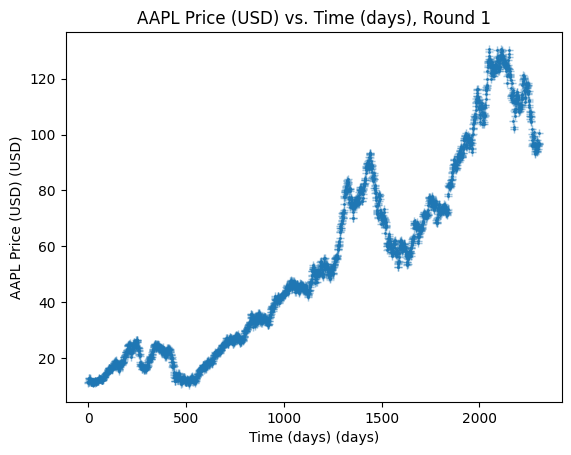

In [5]:
g_opts = GraphingOptions(
    x_label="Time (days)",
    y_label=f"{stock} Price (USD)",
    x_units="days",
    y_units="USD"
)

g_opts.plot_datasets([dataset])

Next, we can build our GBM model. Some reasonable assumptions for the drift $\mu$ and volatility $\sigma$ are a $0.1\%$ daily drift and $2\%$ daily volatility.

In [6]:
model = GBM(
    initial_value = prices[0],
    drift = 1.1e-3,
    drift_bounds = (0,0.1),
    volatility = 2e-2,
    volatility_bounds = (0,1)
)

And now, we can try performing a fit to this data:

In [7]:
result = autofit(dataset, model, graphing_options=g_opts)
print_results(model, result)

,Measurement,Value,Uncertainty,Relative Uncertainty ($\%$):
0,Drift,0.0011,7.666228e-13,6.969298e-08
1,Volatility,0.0200,7.562717e-13,3.781358e-09


Goodness of Fit: $\chi$² = 4219704.834

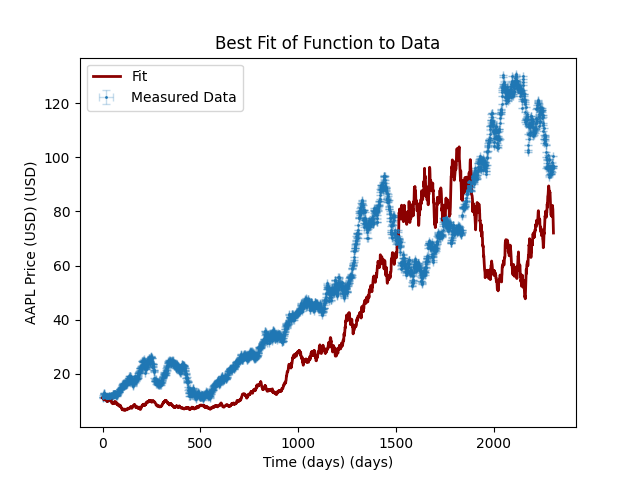

In [8]:
display(result.autofit_graph)

So... it's not a great fit to the data! However, this makes sense. `autofit` is based on `curve_fit`, which minimizes $\chi^2$. Performing a multivariate fit is reaching numerous local minima which are all fairly awful fits to the data. That means that fitting data like this is more or less a manual process, because there are local minima basically everywhere in the $\chi^2$-parameter-space. 

To fix this, however, we can try using machine learning instead. A simple way to do this is to learn the drift $\mu$ from the data, and the `LearnedDriftGBM` model can be used to do this. Once more, we can start by just making a model:

In [9]:
model2 = LearnedDriftGBM(
    initial_value=prices[0],
    volatility=0.02,           # initial guess for volatility
    hidden_units=4,            # complexity of drift network
    volatility_bounds=(1e-3, 1)
)

And now, we can try fitting this to our data instead:

In [10]:
result2 = autofit(dataset, model2, graphing_options=g_opts)
print_results(model2, result2)

/home/mufaro/Programming/experimentalis/venv/lib/python3.12/site-packages/scipy/optimize/_lsq/least_squares.py:965: RuntimeWarning: overflow encountered in dot
  initial_cost = 0.5 * np.dot(f0, f0)
/home/mufaro/Programming/experimentalis/venv/lib/python3.12/site-packages/scipy/optimize/_lsq/trf.py:224: RuntimeWarning: overflow encountered in dot
  cost = 0.5 * np.dot(f, f)
/home/mufaro/Programming/experimentalis/venv/lib/python3.12/site-packages/scipy/optimize/_lsq/common.py:595: RuntimeWarning: overflow encountered in dot
  return J.T.dot(f)
/home/mufaro/Programming/experimentalis/venv/lib/python3.12/site-packages/scipy/optimize/_lsq/common.py:595: RuntimeWarning: invalid value encountered in dot
  return J.T.dot(f)
/home/mufaro/Programming/experimentalis/venv/lib/python3.12/site-packages/scipy/optimize/_lsq/trf.py:291: RuntimeWarning: invalid value encountered in multiply
  diag_h = g * dv * scale


ValueError: array must not contain infs or NaNs

In [ ]:
display(result2.autofit_graph)